In [ ]:
import os
import json
import torch
import clip
import faiss
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
class FashionProductDataset(Dataset):
    def __init__(self, image_dir, style_dir, transform=None):
        self.image_dir = image_dir
        self.style_dir = style_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")][:15000]
        self.valid_entries = []

        for img in self.image_files:
            json_path = os.path.join(style_dir, img.replace(".jpg", ".json"))
            if os.path.exists(json_path):
                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)["data"]
                    _ = Image.open(os.path.join(image_dir, img)).convert("RGB")
                    self.valid_entries.append((img, data))
                except:
                    continue

    def __len__(self):
        return len(self.valid_entries)

    def __getitem__(self, idx):
        filename, data = self.valid_entries[idx]
        img_path = os.path.join(self.image_dir, filename)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        brand = data.get("brandName", "")
        gender = data.get("gender", "")
        base_colour = data.get("baseColour", "")
        article_type = data.get("articleType", {}).get("typeName", "")
        category = data.get("masterCategory", {}).get("typeName", "")
        sub_category = data.get("subCategory", {}).get("typeName", "")
        season = data.get("season", "")
        usage = data.get("usage", "")
        pattern = data.get("articleAttributes", {}).get("Pattern", "")
        desc = data.get("productDisplayName", "")
        material_desc = data.get("productDescriptors", {}).get("description", {}).get("value", "").lower()
        material = ""
        if "cotton" in material_desc:
            material = "cotton"
        elif "polyester" in material_desc:
            material = "polyester"
        elif "spandex" in material_desc:
            material = "spandex"

        text = (
            f"{brand} {category} {sub_category} {gender.lower()} {pattern.lower()} "
            f"{base_colour.lower()} {article_type.lower()} {desc}. "
            f"{season.lower()} {usage.lower()} use. Made of {material}."
        ).strip()
        return image, text, filename

In [ ]:
if all(os.path.exists(p) for p in [
    "clip_image_features.pt", "image_filenames.npy", "image_texts.json", "clip_index.faiss"
]):
    print("✅ Loaded from cache")
    image_features = torch.load("clip_image_features.pt")
    filenames = np.load("image_filenames.npy").tolist()
    with open("image_texts.json", "r") as f:
        texts = json.load(f)
    index = faiss.read_index("clip_index.faiss")
# new=False
# if new:
#  print("old")
else:
    print("⚙️ Running first-time setup (this will take time)...")
    dataset = FashionProductDataset(
    r'D:\archive\fashion-dataset\fashion-dataset\images\\',
    r'D:\archive\fashion-dataset\fashion-dataset\styles\\', transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=32)

    image_features = []
    filenames = []
    texts = []

    with torch.no_grad():
        for images, descriptions, image_ids in dataloader:
            images = images.to(device)
            feats = model.encode_image(images)
            feats = F.normalize(feats, dim=-1)
            image_features.append(feats.cpu())
            filenames.extend(image_ids)
            texts.extend(descriptions)

    image_features = torch.cat(image_features, dim=0)

    # Save cache
    torch.save(image_features, "clip_image_features.pt")
    np.save("image_filenames.npy", np.array(filenames))
    with open("image_texts.json", "w") as f:
        json.dump(texts, f)
    

In [ ]:
index = faiss.IndexFlatIP(image_features.shape[1])
index.add(image_features.numpy())
faiss.write_index(index, "clip_index.faiss")
print("✅ Done. Cache saved.")

In [ ]:
query_image = Image.open(r'D:\archive\fashion-dataset\fashion-dataset\images\1525.jpg').convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4815, 0.4578, 0.4082),
                std=(0.2686, 0.2613, 0.2758))
])

img_tensor = preprocess(query_image).unsqueeze(0).to(device)

# Encode and normalize the query image
with torch.no_grad():
    query_feat = model.encode_image(img_tensor)
    query_feat = F.normalize(query_feat, dim=-1)
D, I = index.search(query_feat.cpu().numpy(), k=5)

In [17]:
query = input("Enter a query: ")
tokenized = clip.tokenize([query]).to(device)

with torch.no_grad():
    query_embed = model.encode_text(tokenized)
    query_embed = F.normalize(query_embed, dim=-1)
D, I = index.search(query_embed.cpu().numpy(), k=5)

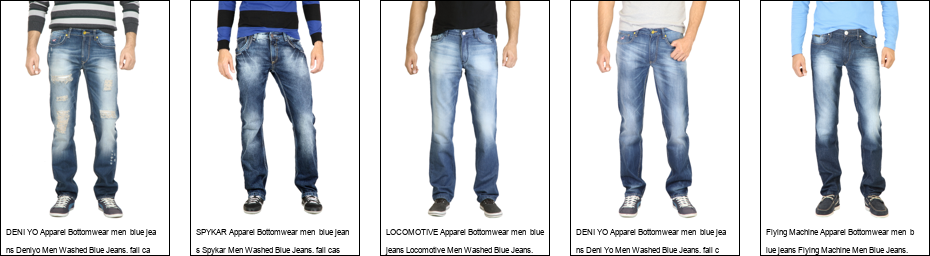

In [18]:

from IPython.display import display, HTML
from PIL import Image,ImageOps,ImageDraw, ImageFont
from IPython.display import display
import io



top_k = 5

images_with_text = []
spacing = 20  # space between image columns
img_size = (224, 224)
font_size = 8

# Load a font (fallback to default if not available)
try:
    font = ImageFont.truetype("arial.ttf", font_size)
except:
    font = ImageFont.load_default()

for idx in I[0][:top_k]:
    filename = filenames[idx]
    text = texts[idx]
    img_path = os.path.join(r'D:\archive\fashion-dataset\fashion-dataset\images', filename)

    with Image.open(img_path).convert("RGB") as img:
        img.thumbnail(img_size)

        # Create image with extra height for text
        dummy_img = Image.new("RGB", (1, 1))
        draw = ImageDraw.Draw(dummy_img)
        bbox = draw.textbbox((0, 0), text[:40], font=font)
        text_height = (bbox[3] - bbox[1]) * 2  # double height for two lines if needed
        text_height = max(text_height, 30)  # ensure minimum height for text
        padded_img = Image.new("RGB", (img.width, img.height + text_height), "white")
        padded_img.paste(img, (0, 0))

        # Draw the text below the image
        draw = ImageDraw.Draw(padded_img)
        draw.text((5, img.height + 2), text[:40], font=font, fill="black")  # truncate long text
        if len(text) > 40:
            draw.text((5, img.height + 20), text[40:80], font=font, fill="black")  # 2nd line if needed

        # Add thin border
        bordered = ImageOps.expand(padded_img, border=1, fill='black')
        images_with_text.append(bordered.copy())

# Combine horizontally
total_width = sum(img.width for img in images_with_text) + spacing * (len(images_with_text) - 1)
max_height = max(img.height for img in images_with_text)

composite = Image.new("RGB", (total_width, max_height), "white")

x_offset = 0
for img in images_with_text:
    composite.paste(img, (x_offset, 0))
    x_offset += img.width + spacing

display(composite)

In [ ]:
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F

# Load and preprocess the query image


# Search using FAISS
D, I = index.search(query_feat, k=5)